<a href="https://colab.research.google.com/github/castudil/bacteria-multi-label/blob/main/multilabel_bac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries used

In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import (f1_score, multilabel_confusion_matrix,
                             accuracy_score, hamming_loss, jaccard_score, make_scorer)
from skmultilearn.ensemble import RakelO

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.calibration import CalibratedClassifierCV

from sklearn.svm import SVC

from joblib import dump, load

In [2]:
os.chdir("..")

In [3]:
train_file = "data/processed/binned/standard/train_e_coli_driams_bin5.csv"
train_bac = pd.read_csv(train_file)
train_bac

,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,...,9970,9975,9980,9985,9990,9995,Ciprofloxacin,Ceftriaxone,Piperacillin-Tazobactam,Cefepime
0,-0.543909,-0.553108,-0.545658,-0.555257,-0.541954,-0.533376,-0.598046,-0.583645,-0.527355,-0.562015,...,-0.630989,-0.586458,-0.619486,-0.581628,-0.547504,-0.495987,0.0,0.0,0.0,0.0
1,-0.057326,-0.136208,-0.144611,-0.157391,-0.159801,-0.158331,0.008426,-0.193531,-0.168365,0.018989,...,-0.389729,-0.363851,-0.370213,-0.300810,-0.307182,-0.349158,1.0,1.0,0.0,1.0
2,0.743918,0.949921,0.719927,0.693647,0.695751,0.681093,0.815381,0.829554,0.632426,0.830530,...,0.942047,1.033130,1.196159,1.023050,0.978259,1.036619,0.0,1.0,0.0,1.0
3,-0.028894,0.012614,-0.006001,-0.025535,0.106127,0.030372,0.069224,0.145514,0.082680,0.138221,...,-0.299958,-0.301746,-0.289887,-0.236411,-0.305851,-0.282742,0.0,0.0,0.0,0.0
4,-0.475705,-0.487146,-0.487743,-0.493327,-0.463534,-0.467391,-0.464390,-0.496199,-0.452918,-0.444487,...,0.149918,-0.039780,-0.062121,-0.145620,0.064877,0.223823,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,0.006170,0.000694,-0.054395,-0.005490,-0.026575,0.000901,0.091051,-0.003546,-0.021516,0.055992,...,0.317729,0.359175,0.313860,0.365343,0.295884,0.360275,0.0,0.0,0.0,0.0
3687,0.163494,0.202147,0.168563,0.167040,0.156675,0.168392,0.110285,0.127895,0.182852,0.141914,...,-0.427474,-0.447680,-0.480857,-0.404797,-0.437589,-0.415309,1.0,1.0,0.0,1.0
3688,-0.174403,-0.194577,-0.267550,-0.215595,-0.186198,-0.228089,-0.195896,-0.105323,-0.234219,-0.213937,...,-0.693727,-0.703768,-0.725724,-0.767433,-0.743913,-0.719988,0.0,0.0,1.0,0.0
3689,-0.330118,-0.298457,-0.292600,-0.290348,-0.291622,-0.281553,-0.353430,-0.370285,-0.286683,-0.327837,...,-0.470829,-0.500840,-0.444321,-0.473418,-0.488421,-0.431619,0.0,0.0,0.0,0.0


In [4]:
test_file = "data/processed/binned/standard/test_e_coli_driams_bin5.csv"
test_bac = pd.read_csv(test_file)
test_bac

,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,...,9970,9975,9980,9985,9990,9995,Ciprofloxacin,Ceftriaxone,Piperacillin-Tazobactam,Cefepime
0,3.347727,2.948922,2.648771,3.026771,3.117332,2.776629,3.842730,2.960835,2.679949,3.416428,...,2.383996,2.587545,2.691533,2.763388,2.800764,2.719323,0.0,0.0,0.0,0.0
1,0.482613,0.478965,0.432382,0.431880,0.458686,0.416456,0.561086,0.725504,0.415529,0.471077,...,-0.034470,0.011846,-0.008484,-0.019991,-0.039981,-0.057099,0.0,0.0,0.0,0.0
2,-0.237068,-0.174734,-0.219508,-0.225590,-0.225767,-0.228955,-0.266639,-0.271604,-0.248955,-0.226421,...,0.227958,0.235476,0.224723,0.277719,0.150839,0.053799,1.0,1.0,0.0,1.0
3,0.660152,0.602329,0.482780,0.817820,0.622456,0.521973,0.614596,0.511479,0.519085,0.697909,...,-0.453232,-0.425189,-0.457277,-0.420105,-0.437057,-0.400817,0.0,0.0,0.0,0.0
4,-0.187392,-0.260014,-0.264912,-0.245390,-0.236072,-0.236808,-0.234062,-0.252400,-0.235212,-0.231586,...,-0.414722,-0.487039,-0.532681,-0.468667,-0.501462,-0.518266,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,-0.370959,-0.357864,-0.370798,-0.394421,-0.371351,-0.374493,-0.440864,-0.336895,-0.356978,-0.386129,...,0.002000,-0.011156,0.011209,0.049686,0.040925,0.046472,0.0,0.0,0.0,0.0
919,0.275823,0.314504,0.256676,0.298257,0.315830,0.211166,0.251178,0.321833,0.221756,0.280306,...,-0.149489,-0.120031,-0.162918,-0.143509,-0.149363,-0.163531,1.0,0.0,0.0,0.0
920,-0.440759,-0.443172,-0.420293,-0.421375,-0.418303,-0.431311,-0.353858,-0.334138,-0.407652,-0.402371,...,-0.474909,-0.399632,-0.433179,-0.411659,-0.478574,-0.534903,0.0,0.0,0.0,0.0
921,-0.393786,-0.410744,-0.371701,-0.408714,-0.402377,-0.384875,-0.466127,-0.438853,-0.417280,-0.427018,...,-0.122456,0.035359,-0.004338,-0.000460,-0.031997,0.049717,0.0,0.0,0.0,0.0


In [5]:
train_x = train_bac[train_bac.columns.drop(list(train_bac.filter(regex='[^0-9]')))]
test_x = test_bac[test_bac.columns.drop(list(test_bac.filter(regex='[^0-9]')))]

In [6]:
antibiotics = train_bac.columns.drop(train_x.columns)

In [7]:
train_y = train_bac[antibiotics]
test_y = test_bac[antibiotics]

In [8]:
train_y_lps = pd.DataFrame()
train_y_lps["Class"] = train_bac[antibiotics].astype(int).astype(str).agg(''.join, axis=1)
train_y_lps["Class"] = train_y_lps["Class"].astype(str)

test_y_lps = pd.DataFrame()
test_y_lps["Class"] = test_bac[antibiotics].astype(int).astype(str).agg(''.join, axis=1)
test_y_lps["Class"] = test_y_lps["Class"].astype(str)

In [9]:
lc = LabelEncoder()
lc.fit(train_y_lps.values.ravel())
train_y_lps = lc.transform(train_y_lps.values.ravel())
test_y_lps = lc.transform(test_y_lps.values.ravel())

In [10]:
# Transforms a one-label instance into a multi-label one.
def lps_to_multilabel_instance(lps_num):
  inverse = lc.inverse_transform([lps_num])
  multilabel_instance = []
  for result in inverse[0]:
      multilabel_instance.append(int(result))
  return multilabel_instance

# Transforms a list of one-label instances into a multi-label one.
def lps_to_multilabel_list(lps_list):
  multilabel_list = []
  for lps_instance in lps_list:
    multilabel_list.append(lps_to_multilabel_instance(lps_instance))
  return multilabel_list

In [11]:
def multilabel_f1_wrapper(true, pred, average="weighted"):
    if isinstance(true, list):
        true = np.array(true)
    elif isinstance(true, pd.DataFrame):
        true = true.to_numpy()
    if isinstance(pred, list):
        pred = np.array(pred)
    elif isinstance(true, pd.DataFrame):
        pred = pred.to_numpy()
    column = 0
    total = 0
    while column < true[0].size:
        total+=f1_score(true[:, column], pred[:, column], average=average)
        column+=1
    return total/(column)

In [12]:
def lps_f1_wrapper(true, pred, average="weighted"):
    non_lps_true = lps_to_multilabel_list(true)
    non_lps_pred = lps_to_multilabel_list(pred)
    return multilabel_f1_wrapper(non_lps_true, non_lps_pred, average=average)

In [13]:
def report(true, pred):
    if not len(pred.shape) > 1:
        true = lps_to_multilabel_list(true)
        pred = lps_to_multilabel_list(pred)
        
    hl = hamming_loss(true, pred)
    f1w = multilabel_f1_wrapper(true, pred, "weighted")
    acc = accuracy_score(true, pred)
    
    f1u = multilabel_f1_wrapper(true, pred, "macro")
    f1su = f1_score(true, pred, average="macro")
    f1sw = f1_score(true, pred, average="weighted")

    
    print("Main metrics:")
    print(" Hamming Loss:", hl)
    print(" Accuracy:", acc)
    print(" F1 Score (Weighted):", f1w)
    print("================================================")
    print("Other metrics:")
    print(" F1 Score (Unweighted):", f1u)
    print(" F1 Score (sklearn Unweighted):", f1su)
    print(" F1 Score (sklearn Weighted):", f1sw)
    return hl, acc, f1w

___


In [14]:
# opt_lps = BayesSearchCV(
#     SVC(),
#     {
#         "C": Real(1e-6, 1000, prior="log-uniform"),
#         "kernel": Categorical(["rbf"]),
#         "gamma": Real(1e-6, 1000, prior="log-uniform"),
#     },
#     n_iter=250,
#     cv=5,
#     random_state=0,
#     n_jobs=5,
#     n_points=2,
#     scoring=make_scorer(lps_f1_wrapper),
#     verbose=1
# )
# np.int = int
# opt_lps.fit(train_x, train_y_lps)

# print("Best score:", opt_lps.best_score_)
# print("Best parameter combination found:", opt_lps.best_params_)

In [15]:
# opt_lps.best_params_

NameError: name 'opt_lps' is not defined

In [18]:
model_file = "svm_lps_e_coli_bin5.joblib"

In [19]:
# dump(opt_lps.best_estimator_, model_file) 

In [20]:
model = load(model_file)

In [21]:
model.fit(train_x, train_y_lps) 
pred = model.predict(test_x)
model_hl, model_acc, model_f1 = report(test_y_lps, pred)

Main metrics:
 Hamming Loss: 0.12296858071505959
 Accuracy: 0.7063921993499458
 F1 Score (Weighted): 0.8664973936459787
Other metrics:
 F1 Score (Unweighted): 0.7269042432853927
 F1 Score (sklearn Unweighted): 0.5288207210800489
 F1 Score (sklearn Weighted): 0.5895651659394028


In [101]:
rakel = RakelO(SVC(C=781.832130079533, gamma=0.0001737643464069402, kernel="rbf"), labelset_size=3, model_count=4)
rakel.fit(train_x, train_y)
rakel_pred = model.predict(test_x)
rakel_model_hl, rakel_model_acc, rakel_model_f1 = report(test_y_lps, rakel_pred)

Main metrics:
 Hamming Loss: 0.12296858071505959
 Accuracy: 0.7063921993499458
 F1 Score (Weighted): 0.8664973936459787
Other metrics:
 F1 Score (Unweighted): 0.7269042432853927
 F1 Score (sklearn Unweighted): 0.5288207210800489
 F1 Score (sklearn Weighted): 0.5895651659394028


In [34]:
results = []
order = []
for params in itertools.combinations(antibiotics, 3):
    params = list(params)

    iter_train_y_lps = pd.DataFrame()
    iter_train_y_lps["Class"] = train_bac[params].astype(int).astype(str).agg(''.join, axis=1)
    iter_train_y_lps["Class"] = iter_train_y_lps["Class"].astype(str)

    iter_test_y_lps = pd.DataFrame()
    iter_test_y_lps["Class"] = test_bac[params].astype(int).astype(str).agg(''.join, axis=1)
    iter_test_y_lps["Class"] = iter_test_y_lps["Class"].astype(str)

    iter_lc = LabelEncoder()
    iter_lc.fit(iter_train_y_lps.values.ravel())
    iter_train_y_lps = iter_lc.transform(iter_train_y_lps.values.ravel())
    iter_test_y_lps = iter_lc.transform(iter_test_y_lps.values.ravel())

    iter_model = SVC(C=781.832130079533, gamma=0.0001737643464069402, kernel="rbf")
    iter_model.fit(train_x, iter_train_y_lps) 
    pred = iter_model.predict(test_x)
    iter_model_hl, iter_model_acc, iter_model_f1 = report(iter_test_y_lps, pred)
    

    multilabel_results = []
    for lps_instance in pred:
        inverse = iter_lc.inverse_transform([lps_instance])
        multilabel_instance = []
        for result in inverse[0]:
            multilabel_instance.append(int(result))
        multilabel_results.append(multilabel_instance)

    results.append(multilabel_results)
    order.append(params)

Main metrics:
 Hamming Loss: 0.16034669555796316
 Accuracy: 0.7172264355362947
 F1 Score (Weighted): 0.8272950667898851
Other metrics:
 F1 Score (Unweighted): 0.6851809385419928
 F1 Score (sklearn Unweighted): 0.46652289047679074
 F1 Score (sklearn Weighted): 0.4873696249543691
Main metrics:
 Hamming Loss: 0.12513542795232935
 Accuracy: 0.7388949079089924
 F1 Score (Weighted): 0.8639980293141887
Other metrics:
 F1 Score (Unweighted): 0.662781499802771
 F1 Score (sklearn Unweighted): 0.39779375341760753
 F1 Score (sklearn Weighted): 0.42059544908702967
Main metrics:
 Hamming Loss: 0.1646803900325027
 Accuracy: 0.71397616468039
 F1 Score (Weighted): 0.820302972192802
Other metrics:
 F1 Score (Unweighted): 0.6560016789533504
 F1 Score (sklearn Unweighted): 0.4078308112440673
 F1 Score (sklearn Weighted): 0.40149358338766145
Main metrics:
 Hamming Loss: 0.07258938244853738
 Accuracy: 0.8179848320693391
 F1 Score (Weighted): 0.919793926607675
Other metrics:
 F1 Score (Unweighted): 0.6773122

In [96]:
final_results = pd.DataFrame(np.zeros((len(test_y_lps), len(antibiotics))), columns=antibiotics)
for i in range(len(results)):
    model_order = order[i]
    reduced_results = np.array(results[i])
    for j in range(len(model_order)):
        final_results[model_order[j]] = final_results[model_order[j]] + reduced_results[:, j]
final_results[antibiotics] = (final_results[antibiotics]/3).round(0)
final_results

,Ciprofloxacin,Ceftriaxone,Piperacillin-Tazobactam,Cefepime
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
918,0.0,0.0,0.0,0.0
919,1.0,0.0,0.0,0.0
920,0.0,0.0,0.0,0.0
921,0.0,0.0,0.0,0.0


In [100]:
rakel_model_hl, rakel_model_acc, rakel_model_f1 = report(test_y.to_numpy(), final_results.to_numpy())

Main metrics:
 Hamming Loss: 0.11755146262188516
 Accuracy: 0.7063921993499458
 F1 Score (Weighted): 0.8726782467549883
Other metrics:
 F1 Score (Unweighted): 0.7414967305889113
 F1 Score (sklearn Unweighted): 0.5548637162645783
 F1 Score (sklearn Weighted): 0.6094046938793464


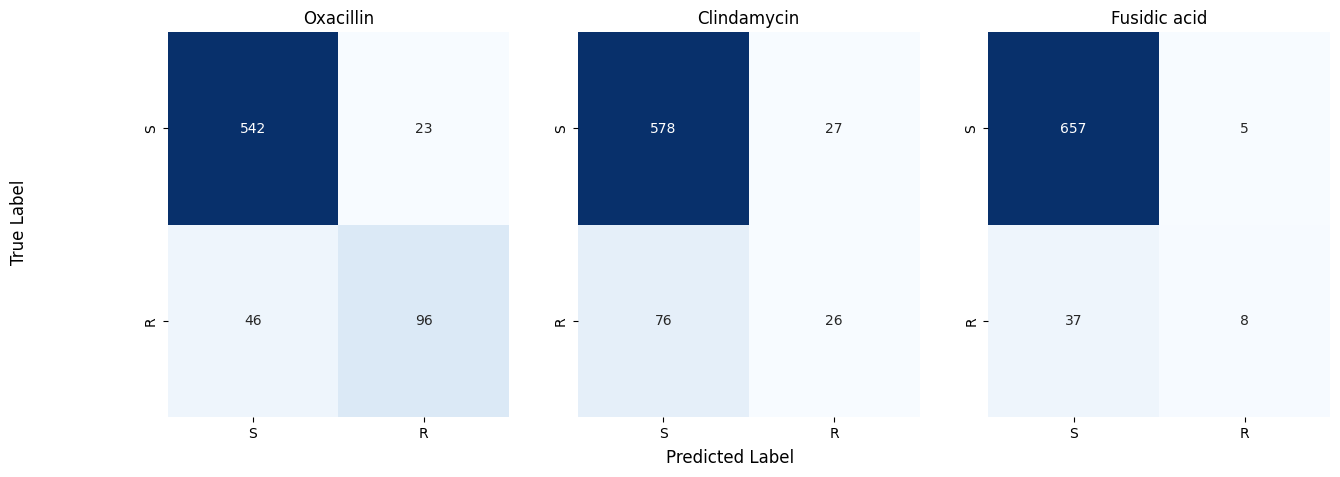

In [ ]:
fig, axes = plt.subplots(1, len(antibiotics), figsize=(len(antibiotics)*5, 5))
fig.supxlabel("Predicted Label")
fig.supylabel("True Label")

cm_svm_c = multilabel_confusion_matrix(test_y, pred)

for i in range(len(antibiotics)):
  sns.heatmap(ax=axes[i], data=cm_svm_c[i], annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=["S", "R"], yticklabels=["S", "R"]).set(title=antibiotics[i])